# Inference statistics for linear regression

We have seen how we can [fit a model](https://github.com/Mashimo/datascience/blob/master/01-Regression/moneyball.ipynb) to existing data using [linear regression](https://github.com/Mashimo/datascience/blob/master/01-Regression/LinearRegression.ipynb). Now we want to assess how well the model describes those data points (every Outcome = Model + Error) and will use some statistics for it. 

As an example we access some available diamond data: prices in Singapore dollars and weights in carats (the standard measure of diamond mass, equal to 0.2 g).  
The diamond data can be downloaded from [the Journal of Statistics Education](http://ww2.amstat.org/publications/jse/jse_data_archive.htm).

In [1]:
import pandas as pd

In [3]:
diamondData = pd.read_csv("diamond.dat.txt", delim_whitespace=True, header=None, names=["carats","price"])

In [4]:
diamondData.head()

,carats,price
0,0.17,355
1,0.16,328
2,0.17,350
3,0.18,325
4,0.25,642


# Fit a model

## Is there a relationship between the diamond price and its weight?

Our first goal should be to determine whether the data provide evidence of an association between price and carats. If the evidence is weak, then one might argue that bigger diamonds are not better!

To evaluate the model we will use a special Python package, **statsmodel**, which has nice available functions for this.  
Statsmodel is a package based on the original - later removed - statistics module of SciPy (Scientific Python) by Jonathan Taylor, corrected, improved, tested and released as a new package during the Google Summer of Code 2009.  

![statsmodels](statsmodels_hybi_banner.png)

In [5]:
import statsmodels.api as sm

Since statsmodels offers also functions to fit a linear regression model, we do not need to import and use *sklearn* to fit the model but we can do everything with *statsmodels*.  
We will use its function *OLS()* that fits a linear regression based on the Ordinary Least Squares algorithm.  

The model we want to get is :  
y_hat = beta0 + beta1 * X

where y_hat is the estimated Diamond Price (the dependent variable) and x is the diamond Weight (the independent variable).  

An intercept is not included by default and should be added by the user:

In [6]:
X = sm.add_constant(diamondData.carats) # this append a column of ones

In [7]:
simpleModel = sm.OLS(diamondData.price, X).fit() # fit the model

In [8]:
simpleModel.params  # here are the beta coefficients (intercept and slope of the linear regression line)

const     -259.625907
carats    3721.024852
dtype: float64

The intercept (beta0) is -259.6 and the slope (beta1) is 3721  
Therefore our simple (one variable only) model looks like:  

Diamond Price = -259.6 + 3721 * Diamond Weight

We can plot the obtained regression line together with the input data X.
We can do it by drawing a line using the beta parameters just calculated or also plotting the fitted values:

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

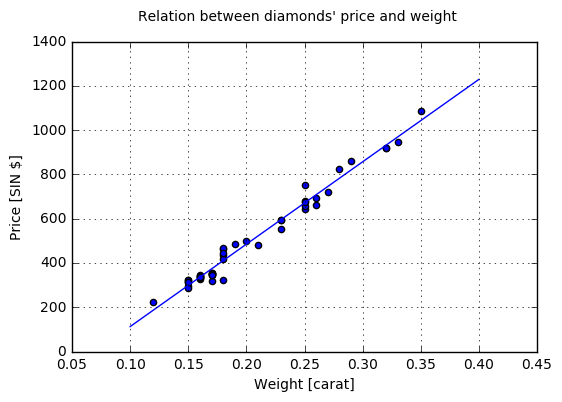

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(diamondData.carats, diamondData.price)
   # draw linear regression line
x = [0.1,0.4]
y = [-259.6 + 3721 * i for i in x] 
ax.plot(x, y)
   # alternatively, plot the fitted values
#y_hat = simpleModel.fittedvalues
#ax.plot(diamondData.carats, y_hat)
   # pretty-up the plot
fig.suptitle("Relation between diamonds' price and weight")
ax.set_ylabel('Price [SIN $]')
ax.set_xlabel('Weight [carat]')
ax.grid(True)

This answers our first question.  
There is a relationship between price and weight of diamond and we can model it.

# Analyse the model

## Which kind of relation is between weight and price?

Next question would be to find out if the relation is linear and how it looks like.

### Coefficients interpretation

Beta1 (the slope of the regression line) is the **expected change in response for a 1 unit change in the predictor.**  
In our case, we expect 3721 Singapore dollars increase in price for every carat increase in mass of diamond.  
This is within the restricted range considered; extrapolation of the regression line for bigger diamond stones would not be advisable as these stones are rarer and command a different price range.

Beta0 (the intercept of the regression line) is the **expected price when the weight is zero.**
This does not always make sense and in our case the negative intercept is even more puzzling because it suggests that a zero-carat diamond ring has a negative economic value!

### Getting a more interpretable intercept

The intercept -259.63 is the expected price of a 0 carat diamond.  
Which does not make much sense (unless you consider it the cost of bothering the diamond expert when you ask the price of a non-existing diamond :) )  

It can be ignored (the model applies only to a restricted range of the data, say starting from 0.1 Carats) or can be an indication that a different model could be more precise, for example a non-linear regression.  

We can also use instead the expected price for a more suitable weight, for example the average diamond weight.

In [11]:
diamondData.carats.mean() # this is the weight mean of our dataset

0.2041666666666667

Instead of X as input for the model, we take X centered around the mean, i.e. we shift X of a value equal to the sample mean:

In [12]:
XmeanCentered = diamondData.carats - diamondData.carats.mean()

In [13]:
XmeanCentered = sm.add_constant(XmeanCentered) # this append a column of ones
meanCenteredModel = sm.OLS(diamondData.price, XmeanCentered).fit() # fit a new model
meanCenteredModel.params

const      500.083333
carats    3721.024852
dtype: float64

As you can see, **the slope is the same as the previous model, only the intercept shifted**.  
This is always valid when you shift your X values.

Thus $500.1 is the **expected price for the average sized diamond** of the initial dataset (=0.2042 carats).  
This is an intercept making much more sense.

You can shift the X input by a certain value but you can also re-scale them.  
This can be useful when one unit is quite large and we would prefer a finer unit.  
For example, in our case, one carat is worth of almost 4K SIN$ and could make sense to talk about tenth of carats (= 1/10). 

In [14]:
Xtenth = diamondData.carats *10 # rescale the X

In [15]:
Xtenth = sm.add_constant(Xtenth)
tenthModel = sm.OLS(diamondData.price, Xtenth).fit() # again fit the model
tenthModel.params

const    -259.625907
carats    372.102485
dtype: float64

**The intercept is the same as in the original model, only the slope coefficient is divided by 10**.  
This is always valid when you re-scale the X values.  

We expect a **372.102 (SIN) dollar change in price for every 1/10th of a carat increase** in mass of diamond.  

# Predicting the price of a diamond

Once we have a model of the relation, we can use it for predictions.  
The statsmodel package has a method *predict()* associated to each model, that takes a new set of input and will output the predicted values, according to the model.

Let's say that I want to buy a 0.2 carats diamond. How much should I expect it to cost?

I can use the beta parameters estimated by the model and just putting them into the linear regression formula:

In [16]:
simpleModel.params[0] + 0.2*simpleModel.params[1]

484.57906311853975

I expect to pay around 485 SIN $.  

Or I can use the *predict()* function available in the *statsmodel* package:

In [17]:
newDiamond = [1, 0.2] # remember to add always the intercept!

In [18]:
simpleModel.predict(newDiamond)

array([ 484.57906312])

It's also possible to pass a list of values to predict:

In [19]:
newDiamonds = sm.add_constant([0.16, 0.27, 0.34]) # add the intecept

In [20]:
simpleModel.predict(newDiamonds)

array([  335.73806906,   745.05080273,  1005.52254234])

Result: for 0.16, 0.27, and 0.34 carats, we predict the prices to be 335.74, 745.05, 1005.52 (SIN) dollars

# Model fit

## How strong is the relationship?

We know that there is a relationship between diamonds carats and prices, we would like to know the strength of this relationship. In other words, given a certain diamond weight, can we predict the price with a high level of accuracy? This would be a strong relationship. Or is a prediction of prices based on weight  only slightly better than a random guess? This would be a weak relationship.

## Residuals

As we have seen previously, the residuals are the difference between the observed (y) and the predicted outcome (y_hat):

In [21]:
y = diamondData.price

In [22]:
y_hat = simpleModel.fittedvalues

In [23]:
max (abs (y - y_hat))

85.158566087530232

Conveniently, residuals are also stored in the results attribute *resid*:

In [24]:
residuals = simpleModel.resid

In [25]:
max(abs(residuals))

85.158566087530232

85 SIN$ (per defect or excess) is the biggest difference done by the model.

Don't confuse errors and residuals.  
The error is the deviation of the observed value from the (unobservable) true value of a quantity of interest (for example, a population mean), and the residual is the difference between the observed value and the estimated value of the quantity of interest (for example, a sample mean).  
 
We can learn many things from the residuals.
One is that their distribution and properties can give us an indication about the model fit.

### Residuals should not show any pattern

The residuals and their plot can highlight a poor model fit.  
Here we plot the residuals versus the fitted values:

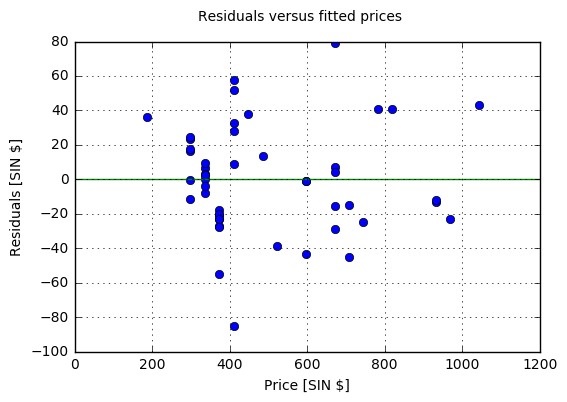

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(simpleModel.fittedvalues, residuals, 'o') # as round marks

   # pretty-up the plot
ax.plot ((0, 1200), (0,0)) # draw also a line at y=0
fig.suptitle("Residuals versus fitted prices")
ax.set_ylabel('Residuals [SIN $]')
ax.set_xlabel('Price [SIN $]')
ax.grid(True)

The residuals should be **distributed uniformly without showing any pattern** and having a constant variance.

If we see from the residuals vs. fitted plot that **the variance of the residuals increases** as the fitted values increase (takes a form of a horizontal cone) this is the sign of **heteroscedasticity**.  

Homoscedasticity describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables and the dependent variable) is the same across all values of the independent variables.  

Heteroscedasticity (the violation of homoscedasticity) is present when **the size of the error term differs across values** of an independent variable.  
Examining the scatterplot of the residuals against the predicted values of the dependent variable would show the classic cone-shaped pattern of heteroscedasticity.

![heteroscedasticity](lme_flu_residuals_fitted5.png)

Other patterns could be:  
- curvilinear  (indicate is non-linear / missing higher-order term)
- a single point is far away from zero (probably an outlier)
- a single point is far away from the others in the x-direction (probably an influential point)

### Residuals should be normally distributed

The **sum of the residuals is expected to be zero** (when there is an intercept).  
This [follows directly from the normal equation](http://stats.stackexchange.com/questions/189584/why-do-residuals-in-linear-regression-always-sum-to-zero-when-an-intercept-is-in), i.e. the equation that the OLS estimator solves. 

In [27]:
sum(residuals)

-7.3896444519050419e-13

The **mean of the residuals is expected to be zero**.  
This [comes directly from the fact that OLS minimises the sum of square residuals](http://math.stackexchange.com/questions/494181/why-the-sum-of-residuals-equals-0-when-we-do-a-sample-regression-by-ols)

In [28]:
import numpy as np

In [29]:
np.mean(residuals)

-1.5395092608135503e-14

This is one of the assumptions for regression analysis: residuals should have a normal (or Gaussian) distribution.

(array([  1.,   1.,   3.,   9.,   8.,  12.,   5.,   6.,   2.,   1.]),
 array([-85.15856609, -68.70574005, -52.25291401, -35.80008797,
        -19.34726193,  -2.89443589,  13.55839015,  30.01121619,
         46.46404223,  62.91686826,  79.3696943 ]),
 <a list of 10 Patch objects>)

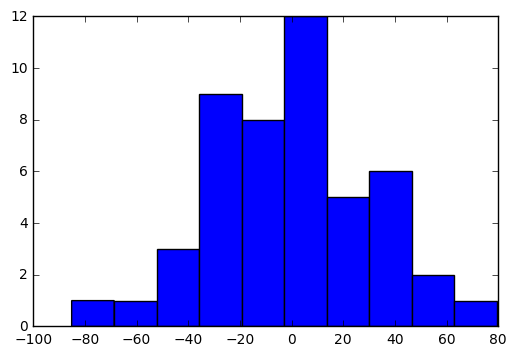

In [30]:
plt.hist(residuals)

It looks normal but we can verify better with a Q-Q plot.

### Q-Q plot to verify the residuals distribution

Q-Q plots (stands for a "quantile-quantile plot") can be used to check whether the data is distributed normally or not.  

It is a plot where the axes are purposely transformed in order to make a normal (or Gaussian) distribution appear in a straight line. In other words, a **perfectly normal distribution would exactly follow a line with slope = 1 and intercept = 0.**

Therefore, if the plot does not appear to be - roughly - a straight line, then the underlying distribution is not normal. If it bends up, then there are more "high flyer" values than expected, for instance.  
The theoretical quantiles are placed along the x-axis. That is, the x-axis is not your data, it is simply an expectation of where your data should have been, if it were normal.

The actual data is plotted along the y-axis.

The values are the standard deviations from the mean. So, 0 is the mean of the data, 1 is 1 standard deviation above, etc. This means, for instance, that 68.27% of all your data should be between -1 & 1, if you have a normal distribution.

*statsmodels* offers a handy *qqplot()* function:

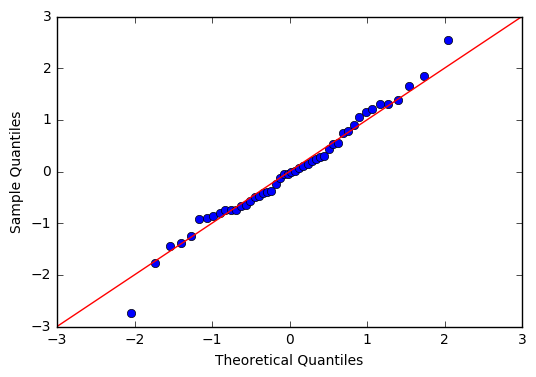

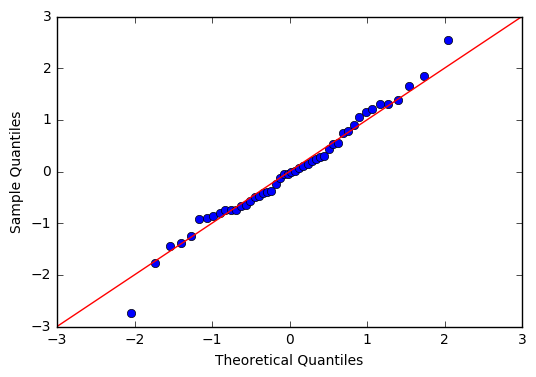

In [31]:
sm.qqplot(residuals, fit=True, line = '45')

## Estimating residual variation

The residual variation measures how well the regression line fits the data points.  

It is the variation in the dependent variable (Price) that is not explained by the regression model and is represented by the residuals. We want the residual variation to be as small as possible.  

Each residual is distributed normally with mean 0 and variance = sigma_squared.    

We have [previously seen](https://github.com/Mashimo/datascience/blob/master/01-Regression/LinearRegression.ipynb) that the ML Estimate of variance, sigma_squared, is sum(residuals squared) divided by n   and we called it the **Mean Squared Error (MSE)**.  
Most people use (n-2) instead of n so that the estimator is unbiased (the -2 is accounting for the degrees of freedom for intercept and slope).      

The square root of the estimate, sigma, is called the **Root Mean Squared Error (RMSE)**.
We want both MSE and RMSE to be as small as possible.

In our diamonds example the estimated residual variation (unbiased RMSE) is :

In [32]:
n = len(y)
MSE = sum(residuals**2) / (n-2)
RMSE = np.sqrt(MSE)
RMSE

31.840522265031755

RMSE can be used to calculate the standardized residuals too.  
They equal the value of a residual divided by an estimate of its standard deviation (so, RMSE).  
Large standardized residuals are an indication of an outlier.

In [33]:
max(simpleModel.resid / RMSE)

2.4927258932276684

### Summarizing the variation: R-squared

The total variation is the residual variation (variation after removing predictors) plus the systematic variation (variation explained by regression model).  

**R-squared** is the percentage of variability explained by the regression model:  

R-squared = explained / total variation = 1 - residual / total variation

R-squared is always between 0 and 1 (0% and 100%):
- 0% indicates that the model explains none of the variability of the response data around its mean.
- 100% indicates that the model explains all the variability of the response data around its mean.  

In general, the higher the R-squared, the better the model fits your data. 

In [34]:
simpleModel.rsquared

0.97826077798603295

We are quite close to a perfect model.

You can use a fitted line plot to graphically illustrate different R-squared values.  
The more variation that is explained by the model, the closer the data points fall to the line. Theoretically, if a model could explain 100% of the variation, the fitted values would always equal the observed values and all of the data points would fall on the  line.

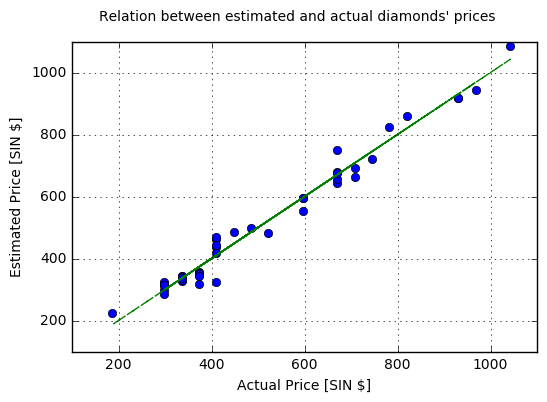

In [35]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(simpleModel.fittedvalues, diamondData.price, 'o') # as round marks
   # identity line
plt.plot(simpleModel.fittedvalues, simpleModel.fittedvalues, '--') 
   # pretty-up the plot
fig.suptitle("Relation between estimated and actual diamonds' prices")
ax.set_ylabel('Estimated Price [SIN $]')
ax.set_xlabel('Actual Price [SIN $]')
ax.grid(True)

 R-squared can be a misleading summary and needs to be carefully taken (deleting data can inflate R-squared for example). 

In conclusion (residuals distribution, variation) the model is pretty good and the relation is very strong.

Because of this, sometimes is preferred to use the **adjusted Rsquared**, which is Rsquared adjusted for the number of observations.  
There are several formula that can be used, normally it is the Wherry's formula:

In [36]:
1 - (1-simpleModel.rsquared)*((n-1)/simpleModel.df_resid)

0.97778818620312058

Of course, it is also available from the model results:

In [37]:
simpleModel.rsquared_adj

0.97778818620312058

# Confidence

## How accurately can we predict the diamond prices?

For any given weight in carats, what is our prediction for the price, and what is the accuracy of this prediction?

In statistics, a sequence of random variables is independent and identically distributed (IID) if each random variable has the same probability distribution as the others and all are mutually independent.

### Inference for regression

In the case of regression with IID sampling assumptions and normal distributed residuals, the statistics for our estimated beta coefficients:  
- will follow a finite sample T-distributions and be normally distributed 
- can be used to test null hypotesis
- can be used to create a confidence interval

In probability and statistics, the [t-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) is any member of a family of continuous probability distributions that arises when estimating the mean of a normally distributed population in situations where the sample size is small and population standard deviation is unknown.  

Whereas a normal distribution describes a full population, t-distributions describe samples drawn from a full population.  

The t-distribution becomes closer to the normal (Gaussian) distribution as its degrees of freedom (df) increases.

![t-distribution](tdistr.png)

The t-distribution arises in a variety of statistical estimation problems where the goal is to estimate an unknown parameter, such as a mean value, in a setting where the data are observed with additive errors.  

If the population standard deviation of these errors is unknown and has to be estimated from the data, the t-distribution is often used to account for the extra uncertainty that results from this estimation.  

Confidence intervals and hypothesis tests are two statistical procedures in which the quantiles of the sampling distribution of a particular statistic (e.g. the standard score) are required. 

Confidence levels are expressed as a percentage (for example, a 95% confidence level). It means that should you take a sample over and over again, 95 percent of the time your results will match the results you get from the population.  

When the population standard deviation sigma is not known, an interval estimate for the population with confidence level (1-alfa) is given by:  
Xmean +- t * (estimated standard error of the mean)  

where t is a critical value determined from the t-distribution in such a way that there is an are (1-alfa) between t and -t.

![interval](tdecrule.gif)

First, we need to calculate the variance.

### Estimating the coefficients and the variance 

Recall that our linear regression model is:  
Y = Beta0 + Beta1 * X + errors  

We can define the beta parameters as:  
beta0 = mean(Y) - beta1 \* mean(X)  
beta1 = Cor(Y,X) \* Sd(Y)/Sd(X)  

For our diamonds example:

In [38]:
  # prepare the data
y = diamondData.price
x = diamondData.carats
n = len(y)

In [39]:
  # calculate beta1
beta1 = (np.corrcoef (y,x) * np.std(y) / np.std(x))[0][1]
beta1

3721.0248515504722

In [40]:
  # calculate beta0
beta0 = np.mean(y) - beta1 * np.mean(x)
beta0

-259.62590719155486

Sigma is unknown but its estimate is the squared root of the sum of the errors squared, divided by n-2 (the degrees of freedom)

In [41]:
e = y - beta0 - beta1 * x # the residuals
  # unbiased estimate for variance
sigma = np.sqrt(sum(e**2) / (n-2))
sigma

31.840522265031737

## Confidence intervals

A 95% confidence interval is defined as a range of values such that with 95% probability, the range will contain the true unknown value of the parameter. 

### Recall of quantiles and percentiles of a distribution

If you were the 95th percentile on an exam, it means that 95% of people scored worse than you and 5% scored better.  
These are sample quantiles.

Now for a population: the *i-th* quantile of a distribution with distribution function *F* is simply the point *x_i* so that :  
F(x_i) = i  

A percentile is simply a quantile with *i* expressed as a percent.  
The 95th percentile of a distribution is the point where the probability that a random variable drawn from the population is less than 95%.

Approximately 68%, 95% and 99% of the **normal** density lies respectively within 1,2 and 3 standard deviations from the mean.

### Estimating the Standard Errors

Now we need to calculate the standard errors.

In [42]:
ssx = sum((x - np.mean(x))**2)

  # calculate standard error for beta0
seBeta0 = (1 / n + np.mean(x) ** 2 / ssx) ** 0.5 * sigma
seBeta0

17.318856186448148

In [43]:
  # calculate standard error for beta1
seBeta1 = sigma / np.sqrt(ssx)
seBeta1

81.785880366042491

The standard error of the parameter measures the precision of the estimate of the parameter.  
The smaller the standard error, the more precise the estimate.

### Hypothesis testing

Hypothesis testing is concerned with making decisions using data.  
A null hypothesis is specified that represents the status quo, usually labeled H0.  
The null hypothesis is assumed true and statistical evidence is required to reject it in favour of an alternative hypothesis.  

![hypotesis](one-sample-t-test.jpg)

Consider testing H0: mu = mu0  
If we take the set of all possible values for which you fail to reject H0, this set is an alfa% confidence interval for mu, alfa depending on the set.

### Getting the T-values

Testing for null hypotesis H0: estimated beta0 and beta1 are equal to real coefficients

Dividing the parameter by its standard error calculates a t-value: 

In [44]:
tBeta0 = beta0 / seBeta0
tBeta0

-14.990938454394572

In [45]:
tBeta1 = beta1 / seBeta1
tBeta1

45.497154703190581

## P-values

P-values are the most common measure of "statistical significance".  

The P-value is the probability under the null hypothesis of obtaining evidence as extreme or more extreme than would be observed by chance alone.  
If the p-value is small, then either H0 is true and we have observed an extreme rare event or H0 is false.  

Let's say a P-value is 0.1: then the probability of seeing evidence as extreme or more extreme than what actually has been obtained under H0 is 0.1 (10%).  

By reporting a P-value, any observer can perform the own hypothesis test at whatever *alfa* level they choose. If the P-value is less than *alfa* then you reject the null hypothesis.

![p-value](pvalue.png)

### Estimating the P-values for hypotesis contrary beta0 is not equal to zero

We can use the T-distribution module from [*SciPy.stats*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html) to calculate the p-values

In [46]:
from scipy.stats import t

The survival function of a random variable is the probability that the random variable is bigger than a value x.  
The *SciPy.stats* function *sf()* returns this probability: 

In [47]:
degreesOfFreedom = simpleModel.df_resid # The residual degree of freedom
pBeta0 = t.sf(abs(tBeta0), df=degreesOfFreedom)*2 # two-sided

In [48]:
pBeta1 = t.sf(abs(tBeta1), df=degreesOfFreedom)*2

Let's summarise the values calculated until now:

In [49]:
print ("##            Estimate     Std. Error    t-value        p-value")
print ("Intercept: ", beta0, seBeta0, tBeta0, pBeta0)
print ("Carats:     ", beta1, seBeta1, tBeta1, pBeta1)

##            Estimate     Std. Error    t-value        p-value
Intercept:  -259.625907192 17.3188561864 -14.9909384544 2.52327062853e-19
Carats:      3721.02485155 81.785880366 45.4971547032 6.75125983495e-40


If the p-value is less than the significance level (0.05 in our case) then the model explains the variation in the response.

### T confidence intervals

For small samples we can use the t-distribution to calculate the confidence intervals.  
The t-distribution has been invented by William Gosset in 1908 and is indexed by a degrees of freedom (*df*): it gets more like a standard normal as *df* gets larger.

*ppf()* is the Percent Point Function from *SciPy.stats*, that has as input the quantile (for a 2-sided 95% probability) and the degrees of freedom.

In [50]:
alpha=0.05 # confidence interval for two-sided hypothesis
qt = 1 - (alpha/2)  # =0.975 for a 2-sided 95% probability
t_value = t.ppf(qt, df=degreesOfFreedom) 
t_value

2.0128955952945886

Now we can calculate the intervals for beta0 and beta1:

In [51]:
limits=[-1,1]
[beta0 + i*t_value*seBeta0 for i in limits]

[-294.48695652479677, -224.76485785831295]

In [52]:
[beta1 + i*t_value*seBeta1 for i in limits]

[3556.3984132043752, 3885.6512898965693]

Interpretation: **With 95% confidence, we estimate that 1 carat increase in diamond size results in a 3556 to 3886 increase in price in (Singapore) dollars.**

### Plot the confidence interval

We calculate the interval for each x value; will use the isf() function to get the inverse survival function:

In [53]:
predicted = simpleModel.fittedvalues
x_1 = simpleModel.model.exog # just the x values plus column of 1
  # get standard deviation of predicted values
predvar = simpleModel.mse_resid + (x_1 * np.dot(simpleModel.cov_params(),
                                                 x_1.T).T).sum(1)
predstd = np.sqrt(predvar)

tppf = t.isf(alpha/2.0, simpleModel.df_resid)

interval_u = predicted + tppf * predstd
interval_l = predicted - tppf * predstd

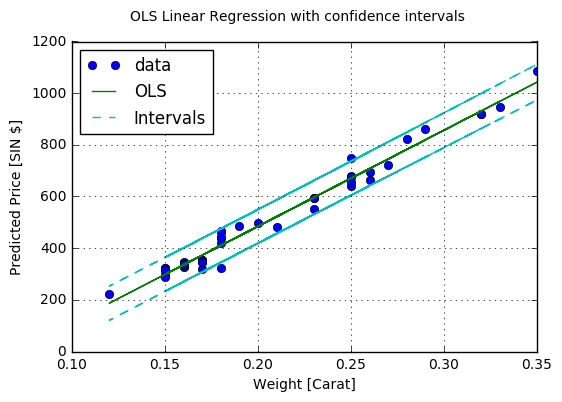

In [54]:
fig, ax = plt.subplots()
ax.plot(x,y, 'o', label="data")
ax.plot(x, simpleModel.fittedvalues, 'g-', label="OLS")

ax.plot(x, interval_u, 'c--', label = "Intervals")
ax.plot(x, interval_l, 'c--')
   # pretty-up the plot
fig.suptitle("OLS Linear Regression with confidence intervals")
ax.set_ylabel('Predicted Price [SIN $]')
ax.set_xlabel('Weight [Carat]')
ax.grid(True)
ax.legend(loc='best')

## Summary of statistic values

The *statsmodel* package offers an overview of the model values, similar to what we calculated above:

In [55]:
simpleModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     2070.
Date:                Sat, 25 Feb 2017   Prob (F-statistic):           6.75e-40
Time:                        13:50:30   Log-Likelihood:                -233.20
No. Observations:                  48   AIC:                             470.4
Df Residuals:                      46   BIC:                             474.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       -259.6259     17.319    -14.991      0.000      -294.487  -224.765
carats      3721.0249     81.786     45.497      0.000      3556.398  3885.651
==============================================================================
Omnibus:                        0.739   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.691   Jarque-Bera (JB):                0.181
Skew:                           0.056   Prob(JB):                        0.913
Kurtosis:                       3.280   Cond. No.                         18.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Many values can also be accessed directly, for example the standard errors:

In [56]:
simpleModel.bse

const     17.318856
carats    81.785880
dtype: float64

You can see all the values available using *dir()*:

In [57]:
dir(simpleModel)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',
 'mse_model',
 'mse_resid',
 'mse_total',